In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def simulate_phase_dynamics(gain, time=1000, v=3, k_0=2 * np.pi / 100, locomotor_strength=0.5,
                             strength_LM=0.1, dt=1):
    def calc_k_A(k_0, gain, locomotor_strength):
        deltaG = gain - 1
        return k_0 * (1 + deltaG * (1 - locomotor_strength))

    def calc_k_L(k_0, gain):
        return k_0 * gain

    def update_position(dt, x, gain, v):
        return (x + dt * gain * v) % 400

    def update_phaseLM(dt, phi_L, k_L, v):
        return (phi_L + dt * k_L * v) % (2 * np.pi)

    def integrate_path_and_landmark_signals(dt, phi_A, x, gain, v, k_A, k_L, strength_LM, phi_L):
        input_vel = k_A * v
        input_LM = strength_LM * np.sin(phi_L - phi_A)
        x_new = update_position(dt, x, gain, v)
        phi_L_new = update_phaseLM(dt, phi_L, k_L, v)
        dphi_A = dt * (input_vel + input_LM)
        phi_A_new = (phi_A + dphi_A) % (2 * np.pi)
        return phi_A_new, x_new, phi_L_new, input_LM

    def calc_decoherence(k_0, v, locomotor_strength, gain, strength_LM):
        return -k_0 * v * locomotor_strength * (gain - 1) / strength_LM

    def find_phase_difference(gain, k_A, k_L, time=1000):
        phi_A = 0
        phi_L = 0
        x = 0

        phi_A_t = []
        phi_L_t = []
        x_t = []
        input_LM_t = []

        for t in range(time):
            phi_A, x, phi_L, input_LM = integrate_path_and_landmark_signals(dt, phi_A, x, gain, v, k_A, k_L, strength_LM, phi_L)
            phi_L_t.append(phi_L)
            phi_A_t.append(phi_A)
            x_t.append(x)
            input_LM_t.append(input_LM)

        phase_difference = [phaseA - phaseL for phaseA, phaseL in zip(phi_A_t, phi_L_t)]
        delta_phi = [(np.pi - dphi) / abs(np.pi - dphi) * ((np.pi - dphi) % np.pi) if abs(dphi) > np.pi else dphi for dphi in phase_difference]
        return phi_A_t, phi_L_t, delta_phi

    k_A = calc_k_A(k_0, gain, locomotor_strength)
    k_L = calc_k_L(k_0, gain)
    decoherence = calc_decoherence(k_0, v, locomotor_strength, gain, strength_LM)

    phi_A_t, phi_L_t, deltaPhi = find_phase_difference(gain, k_A, k_L, time)
    deltaPhi_diff = np.diff(deltaPhi)

    return {
        'gain': gain,
        'decoherence': decoherence,
        'phi_A_t': phi_A_t,
        'phi_L_t': phi_L_t,
        'deltaPhi': deltaPhi,
        'deltaPhi_diff': deltaPhi_diff
    }


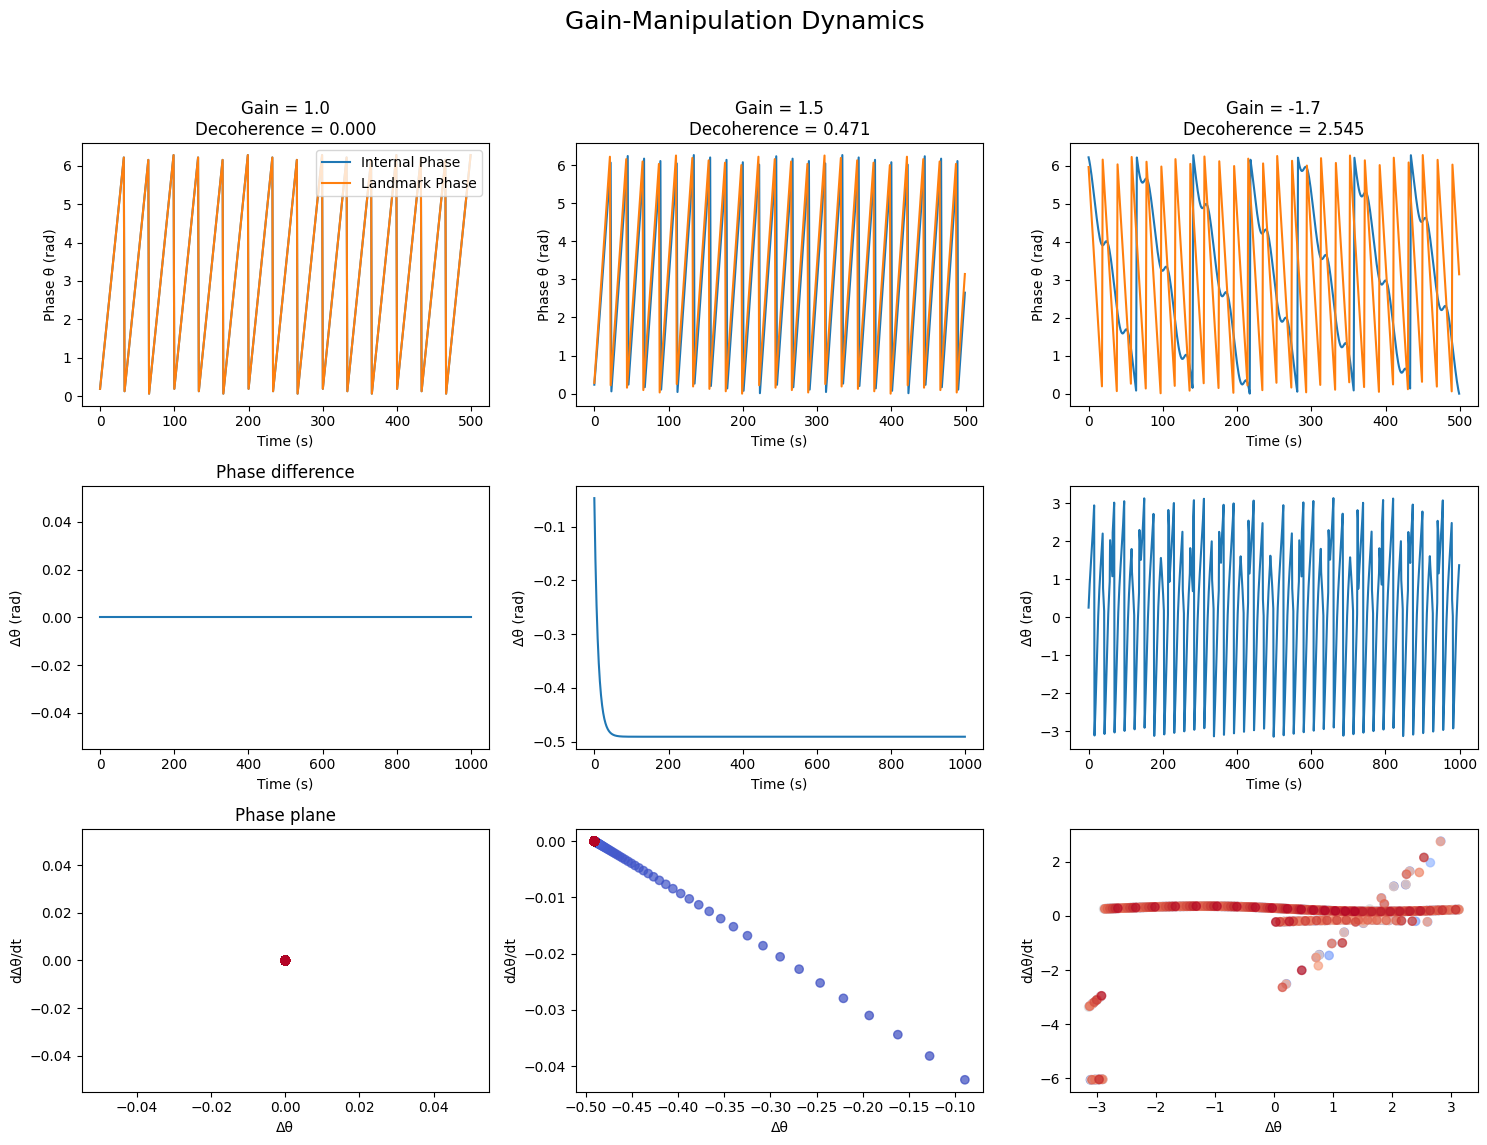

In [11]:

def plot_phase_dynamics(gains, time=1000, dt=1):
    results = [simulate_phase_dynamics(g, time=time, dt=dt) for g in gains]

    n = len(gains)
    fig, axs = plt.subplots(3, n, figsize=(5 * n, 12), sharex=False)

    for col, res in enumerate(results):
        phi_A_t = np.array(res['phi_A_t'])
        phi_L_t = np.array(res['phi_L_t'])
        deltaPhi = np.array(res['deltaPhi'])
        deltaPhi_diff = np.array(res['deltaPhi_diff'])
        T = len(phi_A_t)
        gain = res['gain']
        decoh = abs(res['decoherence'])

        # time vectors
        t0 = np.arange(500) * dt
        t_all = np.arange(T) * dt
        t_vals = np.arange(1, T) * dt  # for coloring phase‐plane

        # phase trajectories
        ax = axs[0, col]
        ax.plot(t0, phi_A_t[:500], label="Internal Phase")
        ax.plot(t0, phi_L_t[:500], label="Landmark Phase")
        ax.set_ylabel("Phase θ (rad)")
        ax.set_xlabel("Time (s)")
        if col == 0:
            ax.legend(loc="upper right")
        ax.set_title(f"Gain = {gain}\nDecoherence = {decoh:.3f}")

        # phase difference
        ax = axs[1, col]
        ax.plot(t_all, deltaPhi)
        ax.set_ylabel("Δθ (rad)")
        ax.set_xlabel("Time (s)")
        if col == 0:
            ax.set_title("Phase difference")

        # phase‐plane with time‐color
        ax = axs[2, col]
        scatter = ax.scatter(
            deltaPhi[1:], deltaPhi_diff,
            c=t_vals, cmap='coolwarm', alpha=0.7
        )
        ax.set_xlabel("Δθ")
        ax.set_ylabel("dΔθ/dt")
        if col == 0:
            ax.set_title("Phase plane")


    fig.suptitle("Gain‐Manipulation Dynamics", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Usage
gains = [1.0, 1.5, -1.7]
plot_phase_dynamics(gains)
